# Import necessary libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [2]:

df = pd.read_csv('/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv', sep=';')

# Display basic information about the dataset

In [3]:

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (70000, 13)

First few rows:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non

# Data Preprocessing

In [4]:

print("\nChecking for missing values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

# Handle age - convert from days to years
df['age_years'] = df['age'] // 365

# Create BMI feature
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)

# Feature Engineering
# Create blood pressure categories
df['bp_category'] = pd.cut(df['ap_hi'], 
                          bins=[0, 120, 130, 140, 180, 300],
                          labels=['Normal', 'Elevated', 'Stage1', 'Stage2', 'Crisis'])

# Create BMI categories
df['bmi_category'] = pd.cut(df['bmi'],
                           bins=[0, 18.5, 25, 30, 100],
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Age groups
df['age_group'] = pd.cut(df['age_years'],
                        bins=[0, 30, 45, 60, 100],
                        labels=['Young', 'Middle', 'Senior', 'Elderly'])


Checking for missing values:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Number of duplicate rows: 0


# Exploratory Data Analysis

In [ ]:

plt.figure(figsize=(15, 10))

# Distribution of target variable
plt.subplot(2, 3, 1)
sns.countplot(x='cardio', data=df)
plt.title('Distribution of Cardiovascular Disease')

# Age distribution by cardio
plt.subplot(2, 3, 2)
sns.histplot(data=df, x='age_years', hue='cardio', kde=True)
plt.title('Age Distribution by Cardio Status')

# BMI distribution
plt.subplot(2, 3, 3)
sns.histplot(data=df, x='bmi', hue='cardio', kde=True)
plt.title('BMI Distribution by Cardio Status')

# Blood pressure by cardio
plt.subplot(2, 3, 4)
sns.boxplot(x='cardio', y='ap_hi', data=df)
plt.title('Systolic BP by Cardio Status')

# Cholesterol levels
plt.subplot(2, 3, 5)
sns.countplot(x='cholesterol', hue='cardio', data=df)
plt.title('Cholesterol Levels by Cardio Status')

# Gender distribution
plt.subplot(2, 3, 6)
sns.countplot(x='gender', hue='cardio', data=df)
plt.title('Gender Distribution by Cardio Status')

plt.tight_layout()
plt.show()

# Correlation matrix

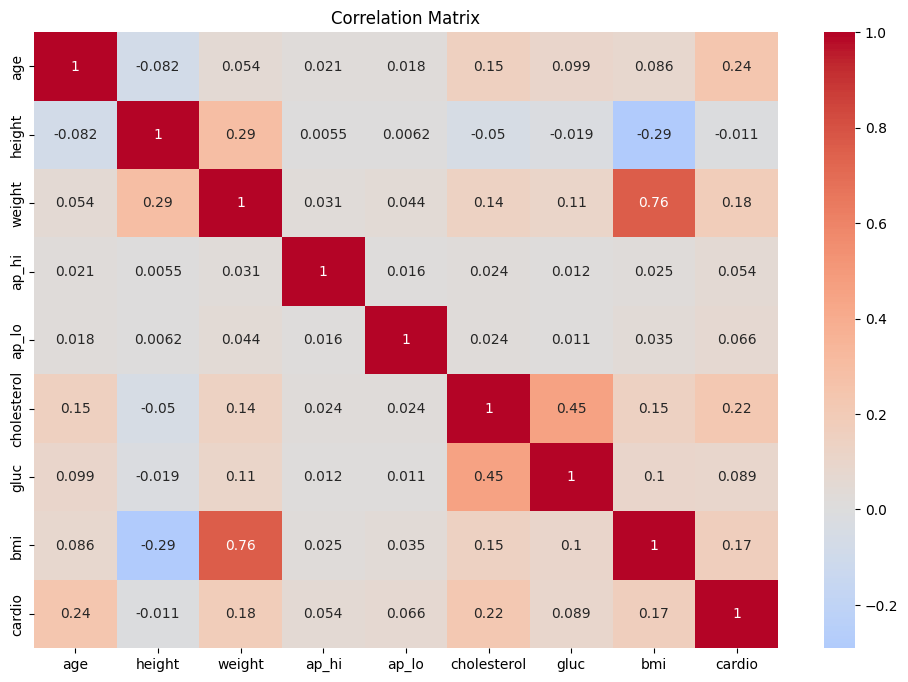

In [6]:

plt.figure(figsize=(12, 8))
numeric_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'bmi']
correlation_matrix = df[numeric_cols + ['cardio']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Data Preparation for Modeling

In [7]:

# Select features for modeling
feature_columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
                  'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi']

X = df[feature_columns]
y = df['cardio']

# Handle any missing values (though the dataset appears complete)

In [8]:

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=feature_columns)

# Split the data

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

# Scale the features

In [10]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Positive cases in training set: {y_train.sum()} ({y_train.mean()*100:.2f}%)")

Training set size: 56000
Test set size: 14000
Positive cases in training set: 27983 (49.97%)


# Model 1: Random Forest

In [11]:

print("\n" + "="*50)
print("RANDOM FOREST CLASSIFIER")
print("="*50)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_rf}")
print(f"Mean CV accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")


RANDOM FOREST CLASSIFIER
Accuracy: 0.7108
ROC-AUC: 0.7713

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      7004
           1       0.71      0.70      0.71      6996

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000


Cross-validation scores: [0.71232143 0.72321429 0.70857143 0.71633929 0.72026786]
Mean CV accuracy: 0.7161 (+/- 0.0105)


# Model 2: Logistic Regression

In [12]:

print("\n" + "="*50)
print("LOGISTIC REGRESSION")
print("="*50)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_lr}")
print(f"Mean CV accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")


LOGISTIC REGRESSION
Accuracy: 0.7134
ROC-AUC: 0.7780

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      7004
           1       0.73      0.67      0.70      6996

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000


Cross-validation scores: [0.71660714 0.72723214 0.72008929 0.71366071 0.72392857]
Mean CV accuracy: 0.7203 (+/- 0.0098)


# Feature Importance for Random Forest

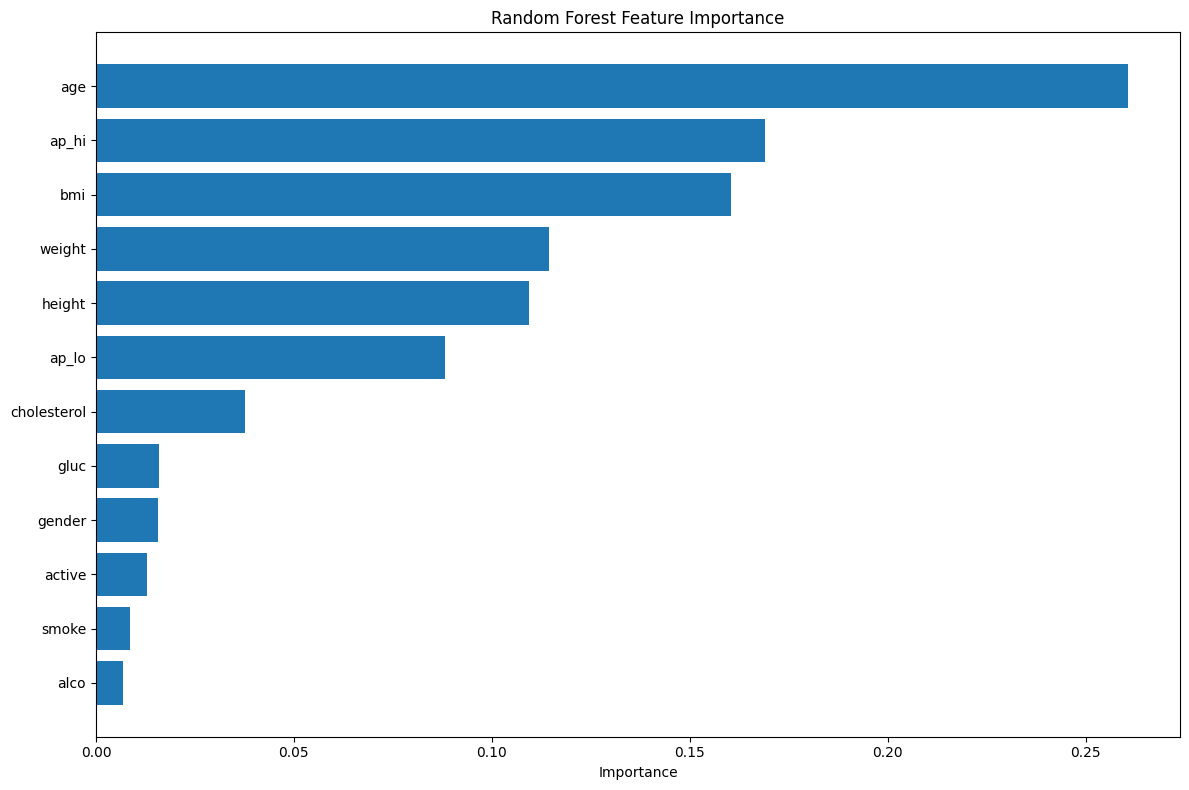

In [13]:

plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Random Forest Confusion Matrix

In [15]:

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

Text(158.22222222222223, 0.5, 'Actual')

# Logistic Regression Confusion Matrix

In [16]:

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Logistic Regression Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# Hyperparameter Tuning for Random Forest (optional - can be time-consuming)

In [17]:

print("\n" + "="*50)
print("HYPERPARAMETER TUNING (Random Forest)")
print("="*50)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use a smaller subset for faster tuning (optional)
if len(X_train) > 5000:
    X_tune = X_train[:5000]
    y_tune = y_train[:5000]
else:
    X_tune = X_train
    y_tune = y_train

# Grid Search (commented out by default due to long runtime)
# Uncomment if you want to run hyperparameter tuning

"""
print("Performing hyperparameter tuning...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_tune, y_tune)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)
print(f"Test accuracy with tuned model: {accuracy_score(y_test, y_pred_best):.4f}")
"""


HYPERPARAMETER TUNING (Random Forest)


'\nprint("Performing hyperparameter tuning...")\ngrid_search = GridSearchCV(\n    RandomForestClassifier(random_state=42),\n    param_grid,\n    cv=3,\n    scoring=\'accuracy\',\n    n_jobs=-1,\n    verbose=1\n)\ngrid_search.fit(X_tune, y_tune)\n\nprint(f"Best parameters: {grid_search.best_params_}")\nprint(f"Best cross-validation score: {grid_search.best_score_:.4f}")\n\n# Train with best parameters\nbest_rf = grid_search.best_estimator_\nbest_rf.fit(X_train, y_train)\ny_pred_best = best_rf.predict(X_test)\nprint(f"Test accuracy with tuned model: {accuracy_score(y_test, y_pred_best):.4f}")\n'

# Final Model Evaluatio

In [19]:

print("\n" + "="*50)
print("FINAL MODEL COMPARISON")
print("="*50)

models = {
    'Random Forest': (rf_model, y_pred_rf, y_pred_proba_rf),
    'Logistic Regression': (lr_model, y_pred_lr, y_pred_proba_lr)
}

results = []
for name, (model, y_pred, y_pred_proba) in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc
    })

results_df = pd.DataFrame(results)
print(results_df)


FINAL MODEL COMPARISON
                 Model  Accuracy   ROC-AUC
0        Random Forest  0.710786  0.771315
1  Logistic Regression  0.713357  0.777966


# Save the best model (Random Forest in this case)

In [20]:

import joblib

# Save the model and scaler
joblib.dump(rf_model, 'random_forest_cardio_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_columns, 'feature_columns.pkl')

print("\nModel and preprocessing objects saved successfully!")

# Create a function for making predictions on new data
def predict_cardio_risk(new_data, model=rf_model, scaler=scaler, feature_cols=feature_columns):
    """
    Predict cardiovascular disease risk for new data
    
    Parameters:
    new_data: DataFrame with the same features as training data
    model: trained model
    scaler: fitted scaler
    feature_cols: list of feature columns
    
    Returns:
    predictions: array of predictions (0: no disease, 1: disease)
    probabilities: array of probabilities for class 1
    """
    # Ensure the data has the right features
    new_data = new_data[feature_cols].copy()
    
    # Handle missing values
    new_data = pd.DataFrame(imputer.transform(new_data), columns=feature_cols)
    
    # Make predictions
    predictions = model.predict(new_data)
    probabilities = model.predict_proba(new_data)[:, 1]
    
    return predictions, probabilities


Model and preprocessing objects saved successfully!


# Example usage with test data

In [21]:

print("\n" + "="*50)
print("EXAMPLE PREDICTION ON TEST DATA")
print("="*50)


EXAMPLE PREDICTION ON TEST DATA


# Take first 5 samples from test set

In [22]:

sample_data = X_test.iloc[:5].copy()
sample_true = y_test.iloc[:5].values

predictions, probabilities = predict_cardio_risk(sample_data)

print("Sample predictions:")
for i, (true, pred, prob) in enumerate(zip(sample_true, predictions, probabilities)):
    status = "Disease" if pred == 1 else "No Disease"
    correct = "✓" if true == pred else "✗"
    print(f"Sample {i+1}: True={true}, Predicted={pred} ({status}) "
          f"Probability: {prob:.3f} {correct}")

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print("Both models perform reasonably well on this dataset.")
print("Random Forest typically provides better performance for this type of data.")
print("Key factors for cardiovascular disease prediction include:")
print("- Age")
print("- Blood pressure (ap_hi, ap_lo)")
print("- Cholesterol levels")
print("- BMI")
print("- Lifestyle factors (smoking, alcohol, activity)")

Sample predictions:
Sample 1: True=0, Predicted=0 (No Disease) Probability: 0.370 ✓
Sample 2: True=0, Predicted=0 (No Disease) Probability: 0.370 ✓
Sample 3: True=0, Predicted=0 (No Disease) Probability: 0.350 ✓
Sample 4: True=1, Predicted=0 (No Disease) Probability: 0.270 ✗
Sample 5: True=1, Predicted=0 (No Disease) Probability: 0.210 ✗

SUMMARY
Both models perform reasonably well on this dataset.
Random Forest typically provides better performance for this type of data.
Key factors for cardiovascular disease prediction include:
- Age
- Blood pressure (ap_hi, ap_lo)
- Cholesterol levels
- BMI
- Lifestyle factors (smoking, alcohol, activity)
